In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from utils import data_utils as du, feature_utils as fu

# Load Data

In [2]:
exchange = "binance"

start_date = "20230101"
end_date = "20241231"

start_dt = dt.datetime.strptime(start_date, "%Y%m%d")
end_dt = dt.datetime.strptime(end_date, "%Y%m%d")

In [3]:
level1_data = du.get_files(start_dt, end_dt, "level1", exchange, "futures", "BTCUSDT")
book_data = du.get_files(start_dt, end_dt, "book", exchange, "futures", "BTCUSDT")
trade_data = du.get_files(start_dt, end_dt, "trade", exchange, "futures", "BTCUSDT")

level1_data.shape, book_data.shape, trade_data.shape

((1052640, 28), (1052640, 63), (1052640, 23))

In [4]:
# Convert timestamps to datetime
level1_data['ts_end'] = pd.to_datetime(level1_data['ts_end'], unit='ms')
book_data[['ts_end', 'ts_book']] = book_data[['ts_end', 'ts_book']].apply(pd.to_datetime, unit='ms')
trade_data['ts_end'] = pd.to_datetime(trade_data['ts_end'], unit='ms')

# Set index to ts_end
level1_data.set_index('ts_end', inplace=True)
book_data.set_index('ts_end', inplace=True)
trade_data.set_index('ts_end', inplace=True)

# Align time series data
(level1_data, book_data, trade_data), start, end = du.align_ts(level1_data, book_data, trade_data)

# Create a common time index
time_idx = pd.date_range(start=start, end=end, freq='1min')

time_idx[[0, -1]]

DatetimeIndex(['2023-01-01 00:01:00', '2024-12-31 23:59:00'], dtype='datetime64[ns]', freq=None)

# Features

#### Level1 Features

In [9]:
taus = [1,5,15, 30, 60, 120]
log_ret_df = fu.feature_log_ret(time_idx, level1_data['close_mid'], taus)
abs_ret_df = fu.feature_abs_ret(time_idx, log_ret_df, taus)
sq_ret_df = fu.feature_sq_ret(time_idx, log_ret_df, taus)

# Target

In [6]:
target_rv_df = fu.target_rv(time_idx, log_ret_df['log_ret_1m'], horizons=[60])

# Correlation

In [10]:
df_corr = pd.concat(
    [log_ret_df, abs_ret_df, sq_ret_df, target_rv_df],
    axis=1
)

corr = df_corr.corr()

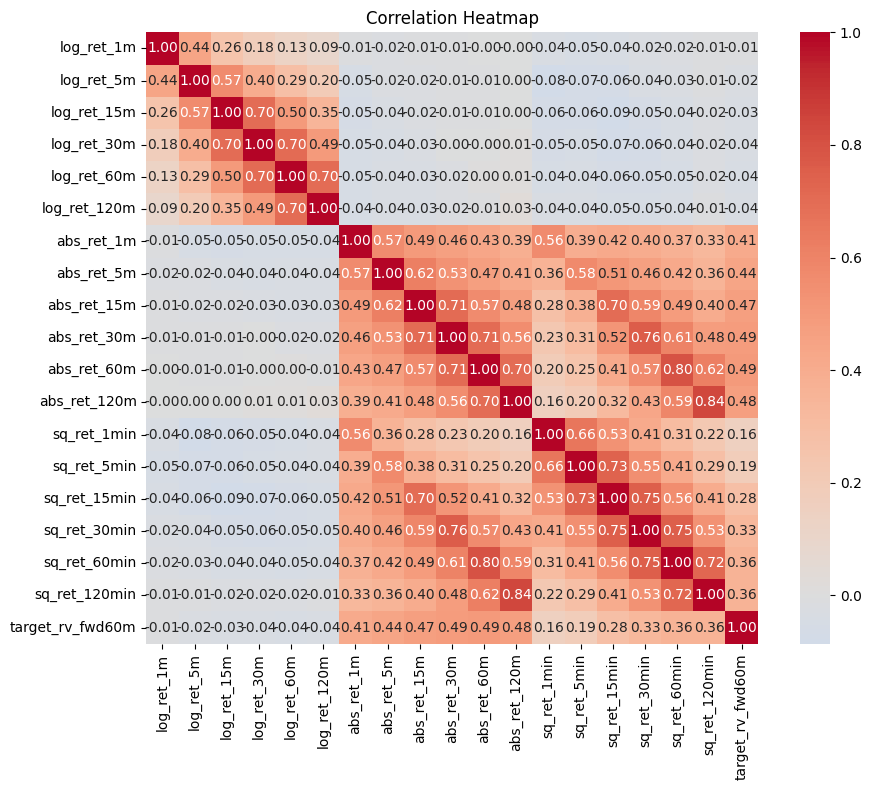

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f",
    square=True
)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()